
# Goal
The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.
For every in the test set, you should predict the correct label.
# Metric
This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

# Submission File Format
The file should contain a header and have the following format:

ImageId,Label
* 1,0
* 2,0
* 3,0
* etc.


<a id="数据集"></a> <br>
# 数据集概览
* 在本教程中，我们将使用“手语数字数据集”。
* 该数据集中包含2062张手语数字图片。
* 数字范围是从0到9。因此共有10个不同的手势。
* 为了简化起见，我们仅使用手势0和1。
* 准备我们的X和Y数组。X是图像数组（手势零和一手势），Y是标签数组（0和1）。

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
# 先用pandas读入csv
from sklearn.model_selection import train_test_split
df = pd.read_csv('train.csv')
Y = df.iloc[:, 0].values   # 标签数据
X = df.iloc[:, 1:].values  # 特征数据
np.save("X.npy", X)
np.save("Y.npy", Y)
X_train = np.load('X.npy')
Y_train = np.load('Y.npy')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

print("数据形状:", X_train.shape) 
print("数据形状:", Y_train.shape) 
print("数据形状:", X_test.shape) 
print("数据形状:", Y_test.shape) 

数据形状: (35700, 784)
数据形状: (35700,)
数据形状: (6300, 784)
数据形状: (6300,)


数据形状: (42000, 784)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
数据形状: (42000,)
[1 0 1 4 0 0 7 3 5 3]


(-0.5, 27.5, 27.5, -0.5)

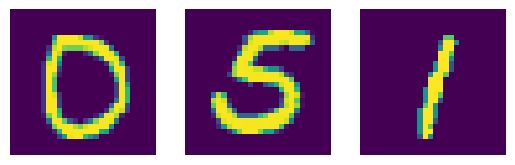

In [3]:
# load data set
img_size = 28
dataX = np.load('X.npy') # 查看数据形状
print("数据形状:", dataX.shape) # 打印前五行数据 
print(dataX[:10])
dataY = np.load('Y.npy') # 查看数据形状
print("数据形状:", dataY.shape) # 打印前五行数据

print(dataY[:10])

plt.subplot(1, 3, 1)
plt.imshow(dataX[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(dataX[900].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(dataX[1500].reshape(img_size, img_size))
plt.axis('off')

* 为手势零的图像创建标签数组，其值为0，为一手势的图像创建标签数组，其值为1

In [4]:
Y_test = Y_test.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)
print("Y_test shape: ", Y_test.shape)
print("Y_train shape: ", Y_train.shape)
print("X_shape: " , X.shape)
print("Y_shape: " , Y.shape)
print("X_test shape: " , X_test.shape)
print("Y_test shape: " , Y_test.shape)

Y_test shape:  (6300, 1)
Y_train shape:  (35700, 1)
X_shape:  (42000, 784)
Y_shape:  (42000,)
X_test shape:  (6300, 784)
Y_test shape:  (6300, 1)


In [5]:
# Then lets create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]
print("X_train number: " , number_of_train)
print("X_test number: " , number_of_test)

X_train number:  35700
X_test number:  6300


* 为方便后续矩阵乘法的计算，对样本矩阵进行转置

In [6]:
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (35700, 784)
x test:  (6300, 784)
y train:  (35700,)
y test:  (6300,)


In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


<!-- <a id="10"></a> <br>
# 深度神经网络(DNN)
* 2-layer 感知机: 
    * 神经网络结构： 包括输入层、一个或多个隐藏层以及输出层。
    * 激活函数： 激活函数提供了非线性变换，使模型具备拟合复杂数据的能力。tanh激活函数比sigmoid更适合用于隐藏单元，因为它的输出均值更接近于零，从而更好地中心化数据以供下一层使用。

<a href="http://ibb.co/eF315x"><img src="http://preview.ibb.co/dajVyH/9.jpg" alt="9" border="0"></a>

   
    
     -->

# Stacking

* 5个CNN

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import time
import sys


class CNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_shape=(28, 28, 1), num_classes=10, epochs=15, batch_size=32):
        self.input_shape = input_shape
        self.num_classes = num_classes  # 设置类别数量为10
        self.epochs = epochs
        self.batch_size = batch_size
        self.classes_ = None  # 添加 classes_ 属性
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential([
            Conv2D(32, (5, 5), activation='relu', input_shape=self.input_shape, padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (5, 5), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, (5, 5), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(self.num_classes, activation='softmax')  # 输出层的节点数设置为10
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)  # 设置 classes_
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)
    
    def predict_proba(self, X):
        return self.model.predict(X)


* 5个互不相同的半训练集

In [9]:
import numpy as np

# 确保数据形状
X_train_reshaped = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], 28, 28, 1))

# 分割数据集，每个子集大小为原始数据集一半且随机抽取
def split_data(X, y, n_splits=5):
    total_size = len(X)
    split_size = total_size // 2
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    X_splits = []
    y_splits = []
    
    for _ in range(n_splits):
        split_indices = np.random.choice(indices, size=split_size, replace=False)
        X_splits.append(X[split_indices])
        y_splits.append(y[split_indices])
        # 从 indices 中移除已经抽取的索引
        indices = np.setdiff1d(indices, split_indices)
        if len(indices) < split_size:  # 如果剩余的样本不足以分成新的子集，重新刷新索引
            indices = np.arange(total_size)
            np.random.shuffle(indices)
    
    return X_splits, y_splits

X_splits, y_splits = split_data(X_train_reshaped, y_train, n_splits=5)


* 初始化5个CNN模型并将其作为基学习器进行堆叠：

In [10]:

# 初始化基学习器
base_learners = [('cnn' + str(i+1), CNNClassifier(epochs=10, num_classes=10)) for i in range(5)]

for i, (name, learner) in enumerate(base_learners):
    learner.fit(X_splits[i], y_splits[i])
    accuracy_train = accuracy_score(y_splits[i], learner.predict(X_splits[i]))
    accuracy_test = accuracy_score(y_test, learner.predict(X_test_reshaped))
    print(f"Weak learner {i+1} train accuracy: {accuracy_train:.8f}")
    print(f"Weak learner {i+1} test accuracy: {accuracy_test:.8f}")



558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Weak learner 1 train accuracy: 0.99008403
Weak learner 1 test accuracy: 0.97793651
558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Weak learner 2 train accuracy: 0.98689076
Weak learner 2 test accuracy: 0.97333333
558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Weak learner 3 train accuracy: 0.98935574
Weak learner 3 test accuracy: 0.97571429
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Weak learner 4 train accuracy: 0.99310924
Weak learner 4 test accuracy: 0.98063492
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Weak learner 5 train accuracy: 0.99142857
Weak learner 5 test accuracy: 0.97777778


* 训练stacking分类器

In [11]:

# 创建Stacking分类器
final_estimator = LogisticRegression(max_iter=1)
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_estimator
)

# 打印训练进度和准确率的回调函数
class TrainingProgressLogger:
    def __init__(self):
        self.iteration = 0

    def __call__(self, clf, X, y):
        self.iteration += 1
        accuracy = accuracy_score(y, clf.predict(X))
        print(f"Iteration {self.iteration}, Accuracy: {accuracy:.8f}")
        sys.stdout.flush()

# 训练Stacking分类器
training_logger = TrainingProgressLogger()
stacking_clf.fit(X_train_reshaped, y_train)




224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
224/224 ━━━━━

StackingClassifier(estimators=[('cnn1', CNNClassifier(epochs=10)),
                               ('cnn2', CNNClassifier(epochs=10)),
                               ('cnn3', CNNClassifier(epochs=10)),
                               ('cnn4', CNNClassifier(epochs=10)),
                               ('cnn5', CNNClassifier(epochs=10))],
                   final_estimator=LogisticRegression(max_iter=1))

* 评估Stacking模型：

In [12]:
# 进行预测并计算准确率
y_pred_train = stacking_clf.predict(X_train_reshaped)
y_pred_test = stacking_clf.predict(X_test_reshaped)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Train Accuracy: {:.8f}%".format(train_accuracy * 100))
print("Test Accuracy: {:.8f}%".format(test_accuracy * 100))


1116/1116 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Train Accuracy: 99.90756303%
Test Accuracy: 99.15873016%
